# Make a catalog to cross-match to for astrometry

Gaia does not seem to have enough stars, nor  does 2MASS

VVV does, but the matches aren't good enough, so we need to use our own...

In [1]:
import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
import regions
from astroquery.vizier import Vizier

In [3]:
from astropy.visualization import quantity_support

In [4]:
%matplotlib inline
import pylab as pl

In [5]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [6]:
#fov = regions.Regions.read(f'{basepath}/regions_/nircam_brick_fov.reg')
fov = regions.Regions.read(f'{basepath}/regions_/brick_fov_2221and1182.reg')

In [7]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53856836, -28.70777756)>,
 <Quantity 270.1901 arcsec>,
 <Quantity 407.1935 arcsec>)

In [8]:
Gaia.ROW_LIMIT = 10000
rslt = Gaia.query_object_async(coordinate=coord, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
gaiacrds = SkyCoord(rslt['ra'], rslt['dec'], frame='icrs')
len(gaiacrds)

556

In [10]:
regs = regions.Regions([regions.PointSkyRegion(crd) for crd in gaiacrds])

In [11]:
regs.write(f'{basepath}/regions_/gaia_sources.reg', overwrite=True)

In [12]:
Vizier.find_catalogs('2MASS Point Source')

OrderedDict([('II/246', </>), ('II/281', </>), ('VII/233', </>)])

In [13]:
Vizier.ROW_LIMIT = 5e4

In [14]:
galnuc2019 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['J/A+A/631/A20'])[0]
galnuc2019[:3]

RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,RAJdeg,e_RAJdeg,DEJdeg,e_DEJdeg,RAHdeg,e_RAHdeg,DEHdeg,e_DEHdeg,RAKsdeg,e_RAKsdeg,DEKsdeg,e_DEKsdeg,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,iJ,iH,iKs
deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,mag,mag,mag,mag,mag,mag,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8
266.49667,0.001945596,-28.701576,0.002423330,266.49667,0.004647948,-28.701575,0.005894406,266.49667,0.002748857,-28.701576,0.003829099,266.49667,--,-28.701578,--,12.60319,0.01797,10.66025,0.02315,9.80017,0.02047,2,2,1
266.49994,0.001945564,-28.706603,0.002423350,266.49994,0.005505896,-28.706602,0.007674307,266.49994,0.007386673,-28.706603,0.009731400,266.49994,0.004654788,-28.706605,0.005909204,14.31819,0.01576,13.68425,0.01060,13.71290,0.00940,2,2,2
266.50150,0.000648518,-28.707176,0.000807787,266.50150,0.009303161,-28.707176,0.011804545,266.50150,0.008525784,-28.707175,0.010064975,266.50150,0.002765908,-28.707176,0.003847118,15.27589,0.01107,13.79975,0.01310,13.25700,0.01679,2,2,2


In [15]:
galnuc2021 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['J/A+A/653/A133'])[0]
galnuc2021[:3]

RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,FJH,FHK,AJ1JH,e_AJ1JH,AH1JH,e_AH1JH,AH1HK,e_AH1HK,AK1HK,e_AK1HK,AH2HK,e_AH2HK,AK2HK,e_AK2HK
deg,arcsec,deg,arcsec,mag,mag,mag,mag,mag,mag,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.49667,0.001945596,-28.701576,0.002423330,12.60319,0.01797,10.66025,0.02315,9.80017,0.02047,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
266.49994,0.001945564,-28.706603,0.002423350,14.31819,0.01576,13.68425,0.01060,13.71290,0.00940,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
266.50150,0.000648518,-28.707176,0.000807787,15.27589,0.01107,13.79975,0.01310,13.25700,0.01679,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000


In [16]:
# FK5 because it says 'J2000' on the Vizier page (same as twomass)
galnuc2021_crds = SkyCoord(galnuc2021['RAJ2000'], galnuc2021['DEJ2000'], frame='fk5')

In [17]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2[:3]
len(vvvdr2)

8700

In [18]:
vvvdr2.write(f'{basepath}/regions_/vvvdr2.fits', overwrite=True)

In [19]:
# FK5 because it says 'J2000' on the Vizier page (same as twomass)
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')

In [20]:
Vizier.ROW_LIMIT = 1e4
twomass = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/246'])[0]
twomass[:3]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
266.499873,-28.750626,17455996-2845022,16.617,--,13.470,--,13.352,0.145,UUB,002,001,00c,0,0
266.498286,-28.758076,17455958-2845290,16.672,--,14.724,--,11.791,0.077,UUA,002,002,00c,0,0
266.496246,-28.751207,17455909-2845043,17.504,--,13.708,0.112,11.703,0.117,UCB,022,012,0cc,0,0


In [21]:
twomass.meta['description'] = '2MASS Point Source Catalog'

In [22]:
twomass.write(f'{basepath}/regions_/twomass.fits', overwrite=True)

In [23]:
# FK5 because it says 'J2000' on the Vizier page
twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

# Test cross-match (to be put in the pipeline when it works)

Work on June 28, 2023

previously had tried F212N, but now using F410M b/c that's our target reference catalog

(maybe F405N is better)


trying f405n...

In [24]:
from astropy.table import Table

In [25]:
filtername = 'f410m'
module = 'nrca'
catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
crowdcatfile = f'{basepath}/{filtername.upper()}/{filtername}_{module}_crowdsource_nsky0.fits'
cat = Table.read(catfile)
cat.write(catfile.replace('ecsv', 'fits'), overwrite=True) # for CARTA viewing
crowdcat = Table.read(crowdcatfile)
len(cat), len(crowdcat)

(6017, 408511)

In [26]:
cat[:3]

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,SkyCoord,SkyCoord,SkyCoord,SkyCoord
1,1570.6974,6.3827,"266.5128528087092,-28.735334548659356",8.459855e-07,1.170607e-07,3.225785e-06,1.625068e-07,5.832813e-06,2.315297e-07,nan,nan,nan,nan,22.628411,0.053363,21.985305,0.042264,nan,nan,nan,nan,19.529943,0.053363,18.886837,0.042264,nan,nan,nan,nan,1.8082,nan,nan,False,0.773871,nan,35,6.142668,6.839110e-05,5.344364e-07,19.312501,0.008451,16.214033,0.008451,39.0,3.586238,1.020146,0.715539,-27.870769,151.198494,"266.51279735649484,-28.735443628339024","266.5129766725367,-28.73544110390799","266.5127925584344,-28.735181573185955","266.5129718740267,-28.735179048761005"
2,1586.1936,8.5287,"266.5128906085183,-28.73506322381704",1.538386e-06,1.557641e-07,1.088467e-04,4.647680e-07,2.057891e-04,6.318318e-07,4.683904e-04,9.671086e-07,6.891429e-04,1.422907e-06,18.807962,0.004626,18.116444,0.003328,17.223480,0.002239,16.804227,0.002239,15.709494,0.004626,15.017976,0.003328,14.125012,0.002239,13.705759,0.002239,1.8906,2.2761,4.3032,False,0.582828,0.983483,1,15.644031,7.818163e-04,1.244522e-06,16.667238,0.001727,13.568770,0.001727,142.0,2.634057,2.430380,0.077324,-51.719794,127.349469,"266.51279223856454,-28.735164102842422","266.5130711738802,-28.735160175857565","266.5127868007937,-28.734867107002188","266.5130657353167,-28.734863180028064"
3,1532.8052,121.5116,"266.51515877084626,-28.735964227035883",1.005472e-05,1.344295e-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,193,60.387234,2.267096e-01,1.143297e-05,10.511325,0.000055,7.412857,0.000055,54406.0,115.547109,49.182062,0.574355,-14.766626,164.302637,"266.5128981213227,-28.740946786518585","266.5180387818796,-28.740874321995058","266.5127426600328,-28.73245619959217","266.5178829029981,-28.73238374075033"


In [27]:
crowdcat[:3]

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,flags,sky,skycoord
,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,int32,float32,SkyCoord
1639.2646713368595,2.663446992635727,387.36435,0.0,0.010919326,0.01751179,4.0852814,0.31331745,855.6598,0.6624993,187.2702,4.5304894,2.6147652,0.0513224,0.0008476956,40.81743,8.445692372853793,-0.6688092123733324,-1073741822,13.536039,"266.51275695366945,-28.734137197735116"
2327.442977964878,-0.499,77776.37,0.0,0.0015924794,0.0045892205,163.00313,0.019378453,40231.83,0.6045297,83243.2,251.98909,2.6151822,-0.000587523,0.00022010396,89743.59,-0.11792440572882117,0.5786438011766161,-1073741822,0.9584287,"266.5124738586608,-28.722115425895083"
201.47764964401722,0.36682572960853577,829054.4,0.0,1e+20,1e+20,10000000000.0,0.0,0.0,0.0,0.0,0.0,2.615182,0.0,0.0,0.0,0.0,0.0,-1073741822,-7.500424,"266.5131711852572,-28.759256363659624"


In [28]:
skycrds_cat = cat['sky_centroid']
skycrds_crowdcat = crowdcat['skycoord']

In [29]:
idx, sidx, sep, sep3d = gaiacrds.search_around_sky(skycrds_cat, 0.2*u.arcsec)
crowdidx, crowdsidx, crowdsep, crowdsep3d = gaiacrds.search_around_sky(skycrds_crowdcat, 0.2*u.arcsec)

In [30]:
len(idx), len(crowdidx)

(58, 652)

In [31]:
dra = (skycrds_cat[idx].ra - gaiacrds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - gaiacrds[sidx].dec).to(u.arcsec)
crowddra = (skycrds_crowdcat[crowdidx].ra - gaiacrds[crowdsidx].ra).to(u.arcsec)
crowdddec = (skycrds_crowdcat[crowdidx].dec - gaiacrds[crowdsidx].dec).to(u.arcsec)

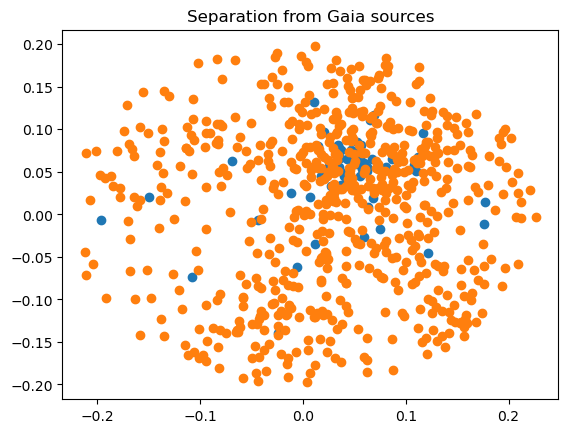

In [32]:
pl.title("Separation from Gaia sources")
pl.scatter(dra, ddec);
pl.scatter(crowddra, crowdddec);

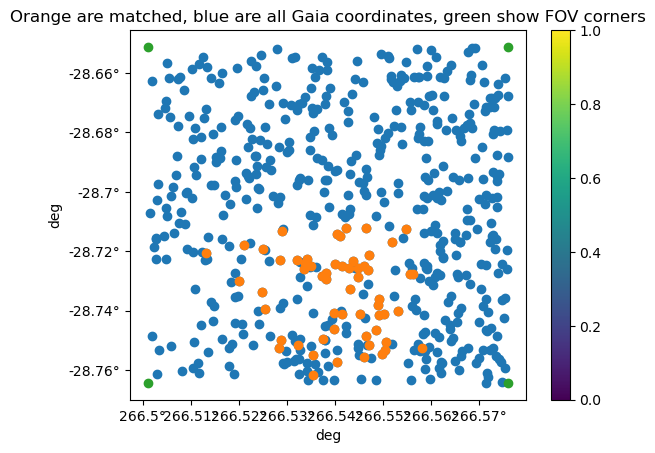

In [33]:
with quantity_support():
    pl.scatter(gaiacrds.ra, gaiacrds.dec)
    pl.scatter(gaiacrds.ra[sidx], gaiacrds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()
    pl.title("Orange are matched, blue are all Gaia coordinates, green show FOV corners")

In [34]:
idx, sidx, sep, sep3d = twomass_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [35]:
len(idx)

66

In [36]:
dra = skycrds_cat[idx].ra - twomass_crds[sidx].ra
ddec = skycrds_cat[idx].dec - twomass_crds[sidx].dec

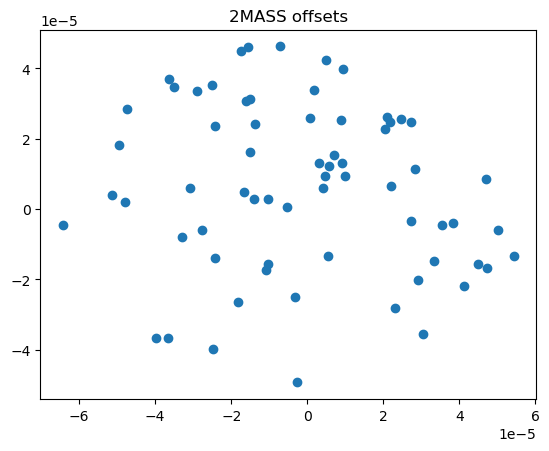

In [37]:
pl.title("2MASS offsets")
pl.scatter(dra, ddec);

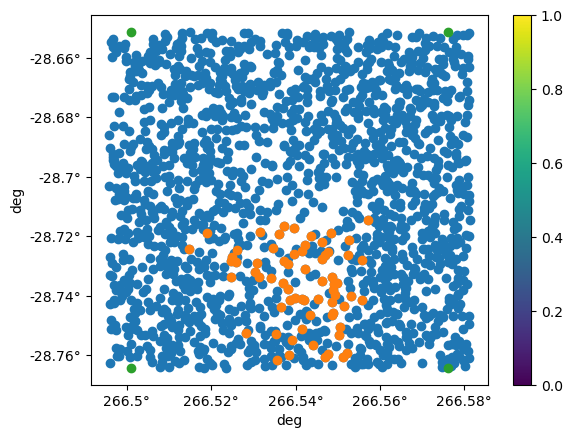

In [38]:
with quantity_support():
    pl.scatter(twomass_crds.ra, twomass_crds.dec)
    pl.scatter(twomass_crds.ra[sidx], twomass_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

In [39]:
idx, sidx, sep, sep3d = galnuc2021_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [40]:
len(idx)

3389

In [41]:
dra = (skycrds_cat[idx].ra - galnuc2021_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - galnuc2021_crds[sidx].dec).to(u.arcsec)

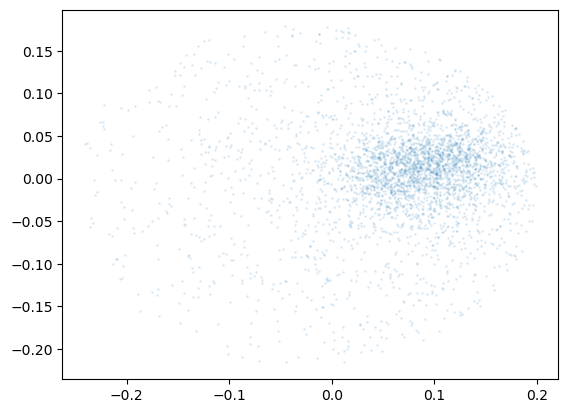

In [42]:
pl.scatter(dra, ddec, s=1, alpha=0.1)

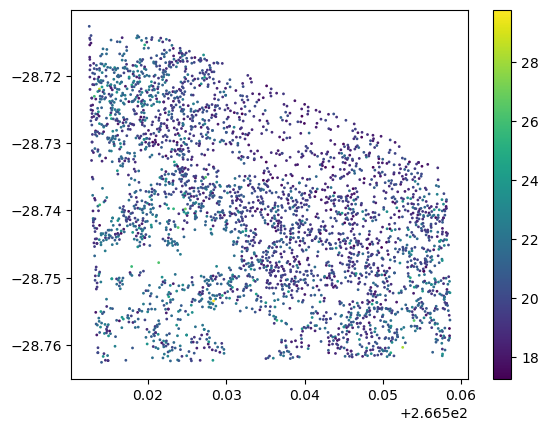

In [43]:
pl.scatter(skycrds_cat[idx].ra, skycrds_cat[idx].dec, c=cat['aper30_abmag'][idx], s=1)
pl.colorbar()

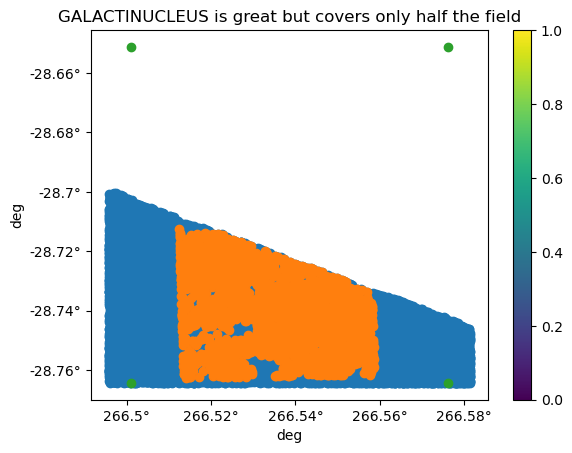

In [44]:
with quantity_support():
    pl.scatter(galnuc2021_crds.ra, galnuc2021_crds.dec)
    pl.scatter(galnuc2021_crds.ra[sidx], galnuc2021_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()
    pl.title("GALACTINUCLEUS is great but covers only half the field")

# VVV offsets

I don't understand what I'm seeing here.  In the CARTA catalog overlay, the VVV sources are not offset (for f410m) - they are aligned with the data.  For F405N, the offset is clear

The crowdsource catalog is perfectly aligned.

How can there be an offset in this plot?

The original catalog (``_cat.ecsv``) is produced by the JWST pipeline.

In [45]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.4*u.arcsec)
downsel = cat['aper_total_vegamag']<15
downselidx, downselsidx, downselsep, downselsep3d = vvvdr2_crds.search_around_sky(skycrds_cat[downsel], 0.4*u.arcsec)

crowdidx, crowdsidx, crowdsep, crowdsep3d = vvvdr2_crds.search_around_sky(skycrds_crowdcat, 0.4*u.arcsec)

In [46]:
len(idx), len(downselidx), len(crowdidx)

(1004, 728, 18774)

In [47]:
dra = (skycrds_cat[idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

crowddra = (skycrds_crowdcat[crowdidx].ra - vvvdr2_crds[crowdsidx].ra).to(u.arcsec)
crowdddec = (skycrds_crowdcat[crowdidx].dec - vvvdr2_crds[crowdsidx].dec).to(u.arcsec)

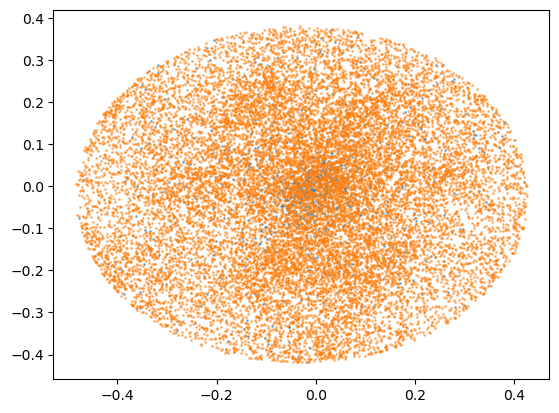

In [48]:
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(crowddra, crowdddec, s=1, alpha=0.5)

In [49]:
downseldra = (skycrds_cat[downsel][downselidx].ra - vvvdr2_crds[downselsidx].ra).to(u.arcsec)
downselddec = (skycrds_cat[downsel][downselidx].dec - vvvdr2_crds[downselsidx].dec).to(u.arcsec)

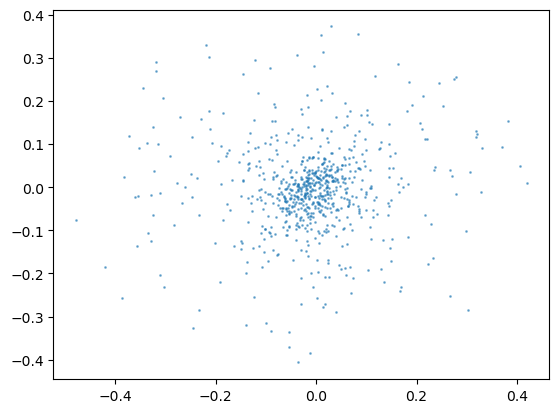

In [50]:
pl.scatter(downseldra, downselddec, s=1, alpha=0.5)
#pl.scatter(crowddra, crowdddec, s=1, alpha=0.5)

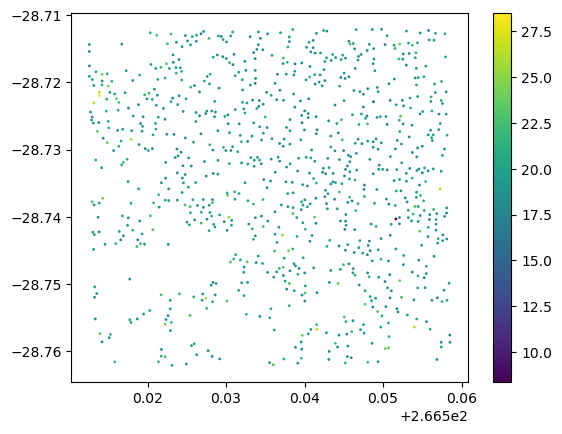

In [51]:
pl.scatter(skycrds_cat[idx].ra, skycrds_cat[idx].dec, c=cat['aper30_abmag'][idx], s=1)
pl.colorbar()

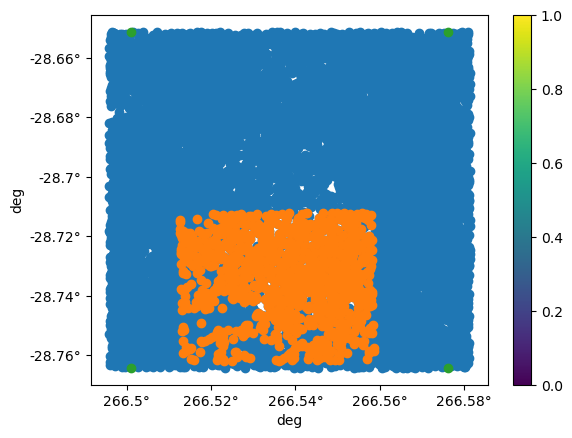

In [52]:
with quantity_support():
    pl.scatter(vvvdr2_crds.ra, vvvdr2_crds.dec)
    pl.scatter(vvvdr2_crds.ra[sidx], vvvdr2_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

# VVV

VVV looks pretty good superposed on the images.

The offset is generally <0.2 arcsec, often <0.1, but there's a systematic shift.

The flux range that matches is:

F187N : ~ 500 - 3000 MJy/sr

F182M, F212N: seems ~same-ish

Actually looks same-ish for the long wave too

Argh, what's the MJy/sr conversion?

In [53]:
from astropy.wcs import WCS
from astropy.io import fits

In [54]:
ww =  WCS(fits.getheader(imfile, ext=('SCI', 1)))
pixscale = ww.proj_plane_pixel_area()

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.661125 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526408297.850 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [55]:
import numpy as np

## Approximate Jy/beam

In [56]:
(u.MJy/u.sr * (2*np.pi * (8*np.log(2)) * 2.5**2 * pixscale)).to(u.Jy)

<Quantity 2.02509284e-05 Jy>

but that doesn't seem to work.

Empirically,

8.5e-5 Jy -> 1933 MJy/sr
1.1e-5 Jy ->  165 MJy/sr
2.1e-5 Jy ->  350 MJy/sr

So there are ~70 nJy / (MJy/sr)

In [57]:
1.1e-5 / 165

6.666666666666667e-08

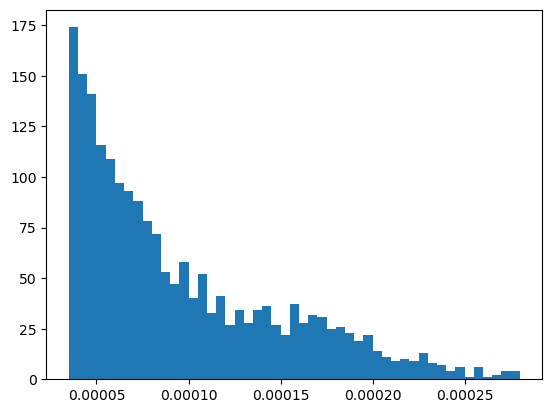

In [58]:
flux = (cat['aper30_abmag'].value * u.ABmag).to(u.Jy)
pl.hist(flux.value, bins=np.linspace(7e-8 * 500, 7e-8 * 4000))
sel = (flux > 7e-8*500*u.Jy) & (flux < 4000*7e-8*u.Jy)

In [59]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat[sel], 0.4*u.arcsec)

In [60]:
len(idx)

568

In [61]:
dra = (skycrds_cat[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

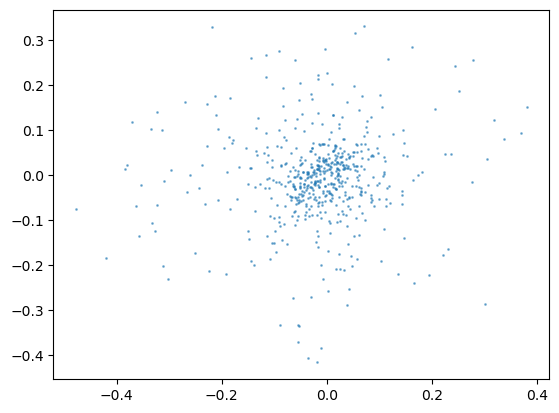

In [62]:
pl.scatter(dra, ddec, s=1, alpha=0.5)

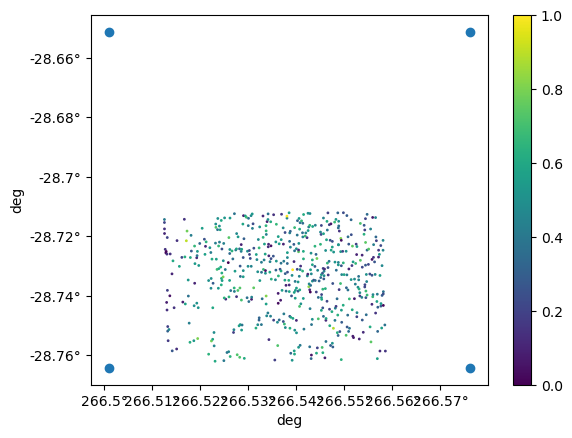

In [63]:
with quantity_support():
    pl.scatter(skycrds_cat[sel][idx].ra, skycrds_cat[sel][idx].dec, c=cat['aper30_abmag'][idx], s=1)
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

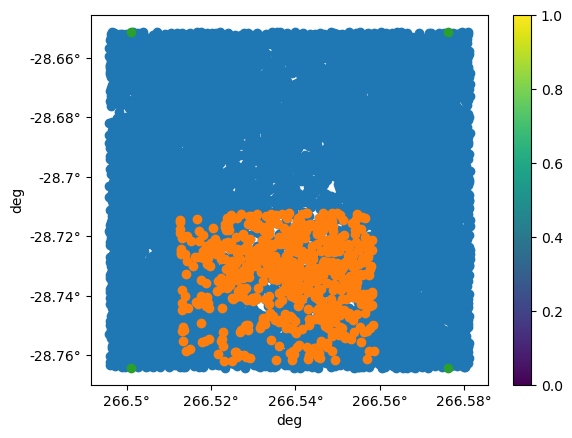

In [64]:
with quantity_support():
    pl.scatter(vvvdr2_crds.ra, vvvdr2_crds.dec)
    pl.scatter(vvvdr2_crds[sidx].ra, vvvdr2_crds[sidx].dec)
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

In [65]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat[sel], 0.4*u.arcsec)
dra = (skycrds_cat[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

-0.0112219 arcsec -0.00296501 arcsec


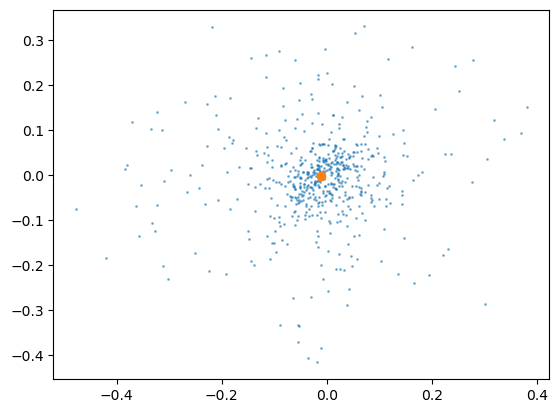

In [66]:
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec))

In [67]:
ww =  WCS(fits.getheader(imfile, ext=('SCI', 1)))
ww.wcs.crval = ww.wcs.crval - [np.median(dra).to(u.deg).value, np.median(ddec).to(u.deg).value]
with fits.open(imfile, mode='update') as hdulist:
    print(hdulist[1].header['CRVAL1'],
          hdulist[1].header['CRVAL2'])
    hdulist[1].header.update(ww.to_header())
    print(hdulist[1].header['CRVAL1'],
          hdulist[1].header['CRVAL2'])

266.5355856147187 -28.737316951295412
266.5355887319 -28.737316127683


Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.661125 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526408297.850 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


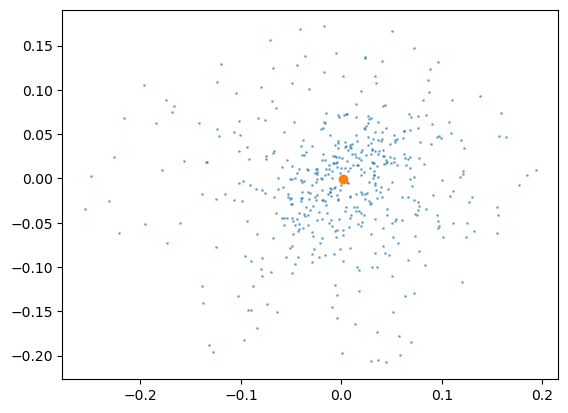

In [68]:
skycrds_cat_new = ww.pixel_to_world(cat['xcentroid'], cat['ycentroid'])

idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat_new[sel], 0.2*u.arcsec)
dra = (skycrds_cat_new[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat_new[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec))

# Check what's happening in the overlap zones

In [69]:
from astropy import wcs

In [70]:
import regions
module_overlap = regions.Regions.read(f'{basepath}/regions_/overlap_region.reg')
module_overlap

<Regions([<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (266.535674, -28.71300934)>, width=11.3759 arcsec, height=150.5041 arcsec, angle=0.0 deg)>])>

In [71]:
import warnings

In [72]:
def check_overlap_zone(filtername = 'f212n'):
    fig = pl.figure(1, figsize=(10,5))
    pl.suptitle(filtername)
    
    ax1 = pl.subplot(1,2,1)
    ax2 = pl.subplot(1,2,2)

    for module in ('nrca', 'nrcb'):
        catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
        imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
        imfile_realigned = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_realigned-to-refcat.fits'
        cat = Table.read(catfile)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ww = wcs.WCS(fits.getheader(imfile_realigned, ext=('SCI', 1)))
        
        skycrds_cat = cat['sky_centroid']
        realigned_skycrds = ww.pixel_to_world(cat['xcentroid'], cat['ycentroid'])
        
        for crds, ax, title in [(skycrds_cat, ax1, 'original'),
                                (realigned_skycrds, ax2, 'realigned')]:
            ax.set_title(title)
            sel = module_overlap[0].contains(crds, ww)

            idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crds, 0.3*u.arcsec)

            dra_all = (crds[idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
            ddec_all = (crds[idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

            idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crds[sel], 0.3*u.arcsec)

            dra = (crds[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
            ddec = (crds[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

            ax.axhline(0, color='k', linestyle=':')
            ax.axvline(0, color='k', linestyle=':')
            ax.scatter(dra_all, ddec_all, s=1, alpha=0.2, label=module)
            ax.scatter(dra, ddec, s=3, alpha=0.5, marker='s', label=module)
            ax.scatter(np.median(dra), np.median(ddec), marker='x', s=100)
            ax.axis([-0.3, 0.3, -0.3, 0.3])
    return fig

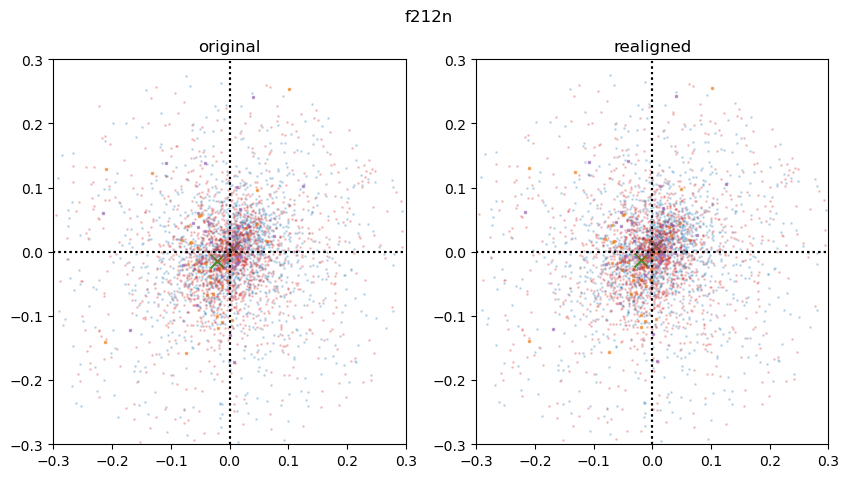

In [73]:
check_overlap_zone('f212n');

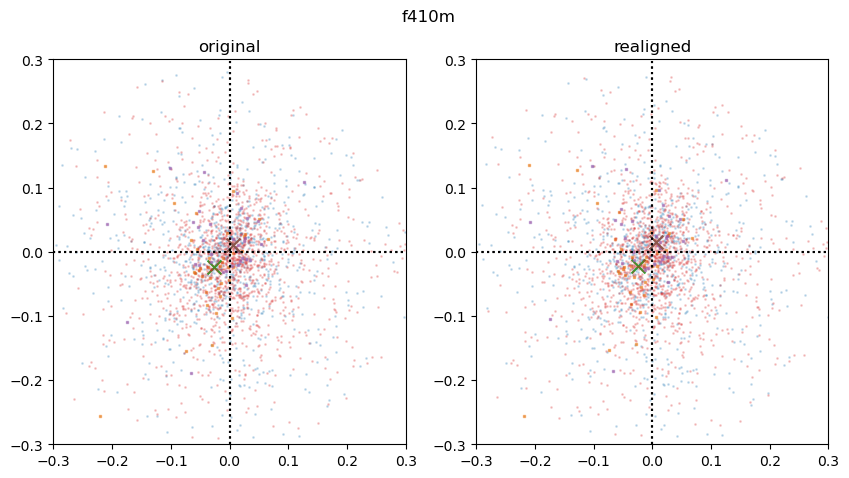

In [74]:
check_overlap_zone('f410m');

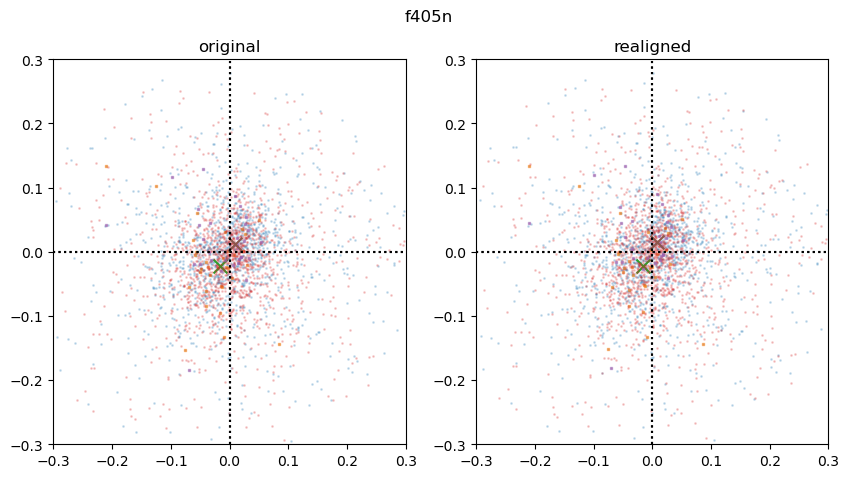

In [75]:
check_overlap_zone('f405n');

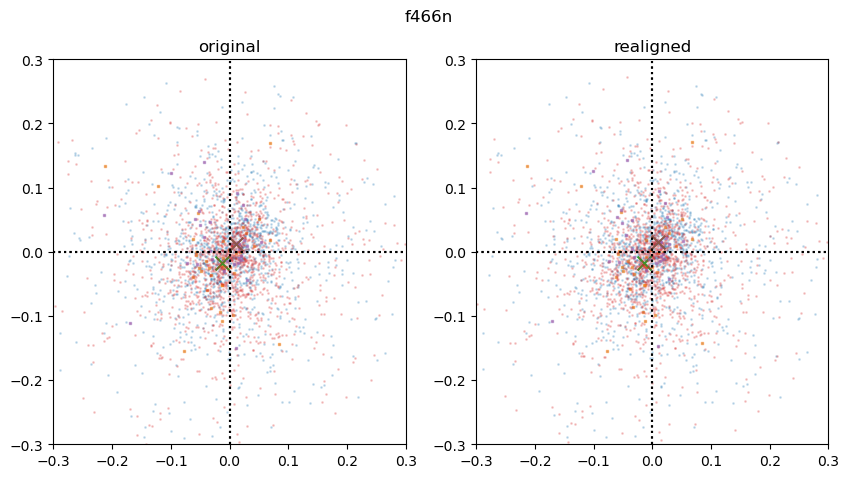

In [76]:
check_overlap_zone('f466n');

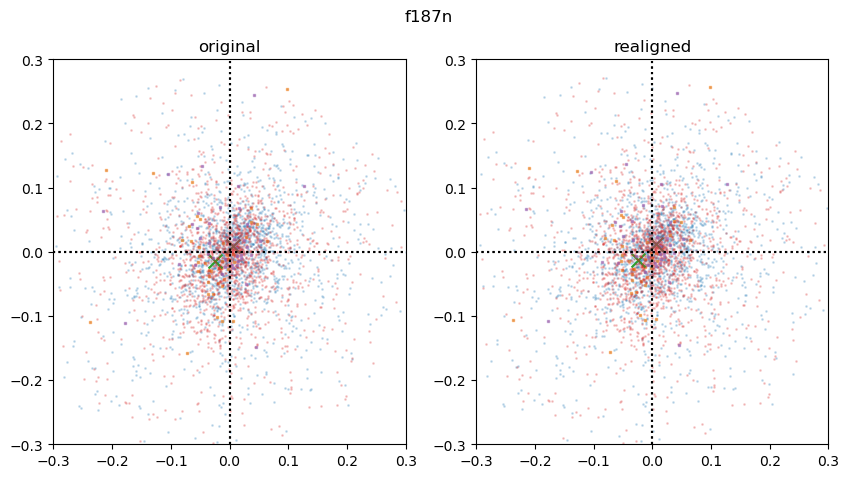

In [77]:
check_overlap_zone('f187n');

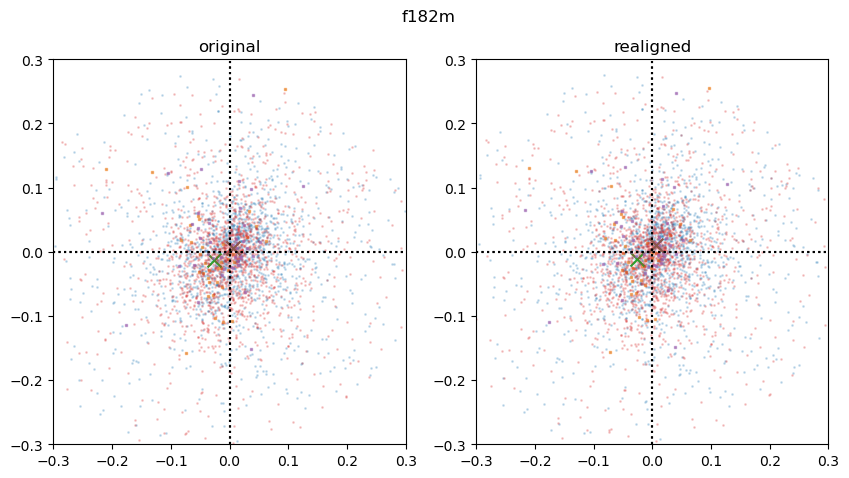

In [78]:
check_overlap_zone('f182m');

# "Production Run" test 

In [79]:
%run $basepath/reduction/align_to_catalogs.py

<Figure size 640x480 with 0 Axes>

In [80]:
# do this in a dedicated slurm job

# TEST aligning using tweakreg

In [81]:
from tweakwcs import JWSTgWCS, align_wcs, JWSTWCSCorrector, FITSWCSCorrector
from astropy.table import Table
from jwst.datamodels import ImageModel

# to update FITS WCS of the data models next import
# requires installing dev version of the pipeline
from jwst.assign_wcs.util import update_fits_wcsinfo


# This only works with L2 files

In [82]:
dm1 = ImageModel(imfile)
dm1.meta.wcs.available_frames

['detector', 'world']

In [83]:
imcat1 = cat
imcat1['x'] = imcat1['xcentroid']
imcat1['y'] = imcat1['ycentroid']
refcat = vvvdr2
refcat['RA'] = refcat['RAJ2000']
refcat['DEC'] = refcat['DEJ2000']

corr1 = FITSWCSCorrector(dm1.get_fits_wcs(),# dm1.meta.wcsinfo.instance,
                 meta={'catalog': imcat1, 'group_id': 1})

# align images to the reference catalog:
aligned_cat = align_wcs([corr1,], refcat=refcat) # + add other arguments as needed - see docs

2024-08-04 15:03:37,746 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.524541 from OBSGEO-[XYZ].
2024-08-04 15:03:37,747 - stpipe - WARNING - Set OBSGEO-B to   -20.661125 from OBSGEO-[XYZ].
2024-08-04 15:03:37,748 - stpipe - WARNING - Set OBSGEO-H to 1526408297.850 from OBSGEO-[XYZ]'.
2024-08-04 15:03:37,749 - stpipe - WARNING -   warnings.warn(
2024-08-04 15:03:37,749 - stpipe - WARNING - 
2024-08-04 15:03:37,751 - stpipe - INFO -  
2024-08-04 15:03:37,752 - stpipe - INFO - ***** tweakwcs.imalign.align_wcs() started on 2024-08-04 15:03:37.751632
2024-08-04 15:03:37,753 - stpipe - INFO -       Version 0.8.8
2024-08-04 15:03:37,753 - stpipe - INFO -  
2024-08-04 15:03:38,014 - stpipe - INFO - Aligning image catalog 'GROUP ID: 1' to the reference catalog.
2024-08-04 15:03:38,021 - stpipe - INFO - Matching sources from 'Unknown' catalog with sources f

dm1.meta.wcs = corr1.wcs
update_fits_wcsinfo(dm1, npoints=16) # <- update FITS WCS too (optionally). Repeat for each model below

# save image models to different files but one can also overwrite existing models:
#dm1.write(imfile.replace(".fits", "_wcscorrected_vvv.fits"))

# Crossmatch F212N with VVV, then we'll save that and use it as our reference case


Work done Oct 20, 2022

Idea is to establish a new and *usable* master table, since VVV stars are mostly saturated in JW.

In [84]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick'

In [85]:
cd $basepath

/blue/adamginsburg/adamginsburg/jwst/brick


In [86]:
filtername = 'f212n'
module = 'nrca'
catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
cat = Table.read(catfile)
#cat.write(catfile.replace('ecsv', 'fits'), overwrite=True) # for CARTA viewing

Catalogs:

 * F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_cat.ecsv
 * F212N/f212n_?merged?_crowdsource.fits doesn't exist yet
 * F212N/f212n_?merged?_daophot_iterative.fits doesn't exist yet

In [87]:
# TODO: replace nrca w/full

crowdtbl = Table.read('F212N/f212n_nrca_crowdsource.fits')
crowdheader = fits.getheader('F212N/f212n_nrca_crowdsource.fits')
daobasictbl = Table.read('F212N/f212n_nrca_daophot_basic.fits')
daoitertbl = Table.read('F212N/f212n_nrca_daophot_iterative.fits')
len(crowdtbl), len(daobasictbl), len(daoitertbl)

(152674, 139289, 175208)

In [88]:
if 'skycoord' not in crowdtbl.colnames:
    print ("Swapping coords")
    # I've now fixed crowdtbl to include skycoord, but it hasn't run yet
    ww = wcs.WCS(crowdheader)
    # crowdtbl are still backwards now
    crowdtbl['skycoord'] = ww.pixel_to_world(crowdtbl['y'], crowdtbl['x'])

In [89]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daobasictbl['skycoord_centroid'], 0.5*u.arcsec)
dra = (daobasictbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daobasictbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

2024-08-04 15:03:39,534 - stpipe - INFO - 2024-08-04T15:03:39.533312: -0.0074893 arcsec -0.0143671 arcsec


INFO: 2024-08-04T15:03:39.533312: -0.0074893 arcsec -0.0143671 arcsec [__main__]
2024-08-04T15:03:39.533312: -0.0074893 arcsec -0.0143671 arcsec


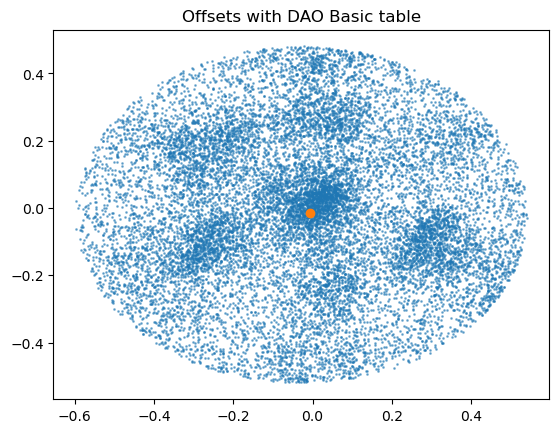

In [90]:
pl.title("Offsets with DAO Basic table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

In [91]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daoitertbl['skycoord_centroid'], 0.5*u.arcsec)
dra = (daoitertbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daoitertbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

2024-08-04 15:03:39,812 - stpipe - INFO - 2024-08-04T15:03:39.812520: -0.0138199 arcsec -0.018242 arcsec


INFO: 2024-08-04T15:03:39.812520: -0.0138199 arcsec -0.018242 arcsec [__main__]
2024-08-04T15:03:39.812520: -0.0138199 arcsec -0.018242 arcsec


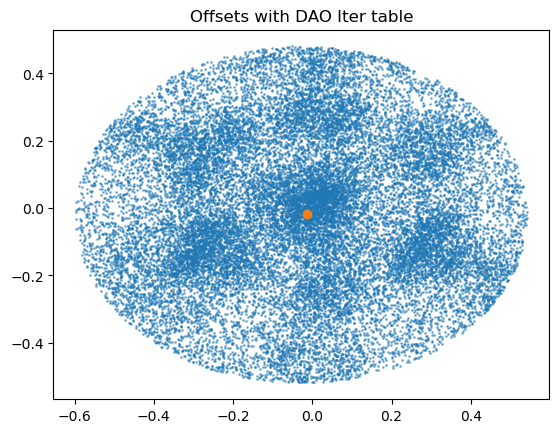

In [92]:
pl.title("Offsets with DAO Iter table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

In [93]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crowdtbl['skycoord'], 0.5*u.arcsec)
dra = (crowdtbl['skycoord'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (crowdtbl['skycoord'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

2024-08-04 15:03:40,228 - stpipe - INFO - 2024-08-04T15:03:40.226845: -0.0185652 arcsec -0.0130552 arcsec


INFO: 2024-08-04T15:03:40.226845: -0.0185652 arcsec -0.0130552 arcsec [__main__]
2024-08-04T15:03:40.226845: -0.0185652 arcsec -0.0130552 arcsec


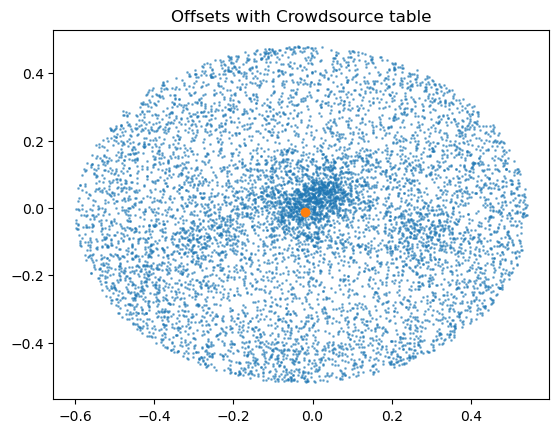

In [94]:
pl.title("Offsets with Crowdsource table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

### Intermediate conclusions:

The iter table performed best but still quite poorly.  Only matches within <0.15 arcsec are remotely valid, so more source rejection is needed to get a good result.

In [95]:
satstarcat = Table.read('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d_satstar_catalog.fits')
if 'skycoord_fit' not in satstarcat.colnames:
    ww = WCS(fits.getheader('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d.fits', ext=('SCI', 1)))
    satstarcat['skycoord_fit'] = ww.pixel_to_world(satstarcat['x_fit'], satstarcat['y_fit'])
    satstarcat.write('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d_satstar_catalog.fits', overwrite=True)
satstarcat[:5]

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags,skycoord_fit
,,,,,,,,,,,,,,,,,"deg,deg"
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,SkyCoord
1,1,1,0.0,4338.066666666667,2444.8333333333335,5177757.2353273565,4338.78318375929,2445.0196963207695,30462152.40281603,0.005319505855346055,0.005645583650550788,146913.71841258658,40299,0.10241683686081138,--,1,"266.53610799723685,-28.725169969702538"
1,1,1,0.0,7151.2,605.5,1543012.8392703952,7150.811371913919,605.2279034309219,5469363.039438506,0.0028412596570036937,0.002691374938082935,9818.37515310386,40363,0.2339653750351511,--,1,"266.51723432241835,-28.701182291366276"
2,2,1,0.0,3262.6,1801.6,2267646.4947893554,3262.8200411134403,1801.778447868529,7971882.989512093,0.0019097402333602988,0.0017362529534932782,10367.875809930882,40352,0.1494661952467176,--,1,"266.5300109288002,-28.734636730045647"
3,3,1,0.0,6201.882352941177,2474.294117647059,3006613.3138852734,6201.937163884645,2474.278686385995,10773131.314075377,0.0024162470504015703,0.002015779114900624,17640.748947598062,40348,0.1441729056212307,--,1,"266.53594150271243,-28.709009628334734"
4,4,1,0.0,6928.461538461538,3593.153846153846,2681657.0150577943,6928.256901372366,3593.0965041197796,9549070.01870665,0.0017362616641584082,0.0015883743554701317,10414.02462099684,40356,0.12515356838968195,--,1,"266.54682324208693,-28.702471786726253"


### Try to reject sources near saturated sources (about 0.4" in F4* and 0.95" (?!?!) in F1*)

In [96]:
satcrd = satstarcat['skycoord_fit']
daoitercrd = daoitertbl['skycoord_centroid']
idx_s, sidx_s, sep_s, sep3d_s = satcrd.search_around_sky(daoitertbl['skycoord_centroid'], 0.95*u.arcsec)
len(idx_s), len(sidx_s), len(sep_s), len(sep3d_s)

(3183, 3183, 3183, 3183)

In [97]:
inds = np.arange(len(daoitercrd))
unsat_inds = inds[~np.in1d(inds, idx_s)]
#daoitercrd_nosat = daoitercrd[unsat_inds]
daoitertbl_nosat = daoitertbl[unsat_inds]

In [98]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daoitertbl['skycoord_centroid'], 0.5*u.arcsec)
sat_idx = np.isin(idx, idx_s)
dra = (daoitertbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daoitertbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
dra_s = (daoitertbl['skycoord_centroid'][idx[sat_idx]].ra - vvvdr2_crds[sidx[sat_idx]].ra).to(u.arcsec)
ddec_s = (daoitertbl['skycoord_centroid'][idx[sat_idx]].dec - vvvdr2_crds[sidx[sat_idx]].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

2024-08-04 15:03:41,033 - stpipe - INFO - 2024-08-04T15:03:41.032612: -0.0138199 arcsec -0.018242 arcsec


INFO: 2024-08-04T15:03:41.032612: -0.0138199 arcsec -0.018242 arcsec [__main__]
2024-08-04T15:03:41.032612: -0.0138199 arcsec -0.018242 arcsec


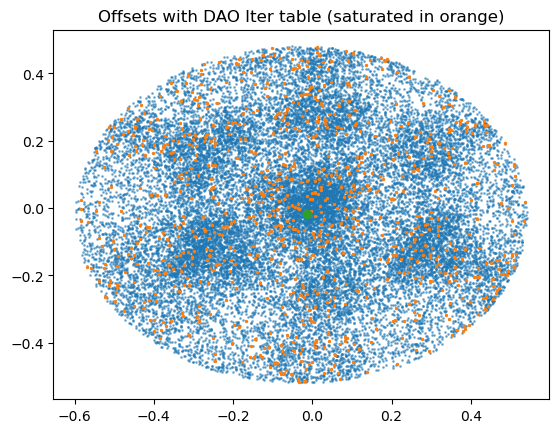

In [99]:
pl.title("Offsets with DAO Iter table (saturated in orange)")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(dra_s, ddec_s, s=2, alpha=1)
pl.scatter(np.median(dra), np.median(ddec));

## Try to match saturated star centroids

In [100]:
satcrd = satstarcat['skycoord_fit']
idx_s, sidx_s, sep_s, sep3d_s = satcrd.search_around_sky(vvvdr2_crds, 0.5*u.arcsec)
dra_s = (satcrd[sidx_s].ra - vvvdr2_crds[idx_s].ra).to(u.arcsec)
ddec_s = (satcrd[sidx_s].dec - vvvdr2_crds[idx_s].dec).to(u.arcsec)
len(idx_s), len(satcrd), len(vvvdr2_crds)

(51, 51, 8700)

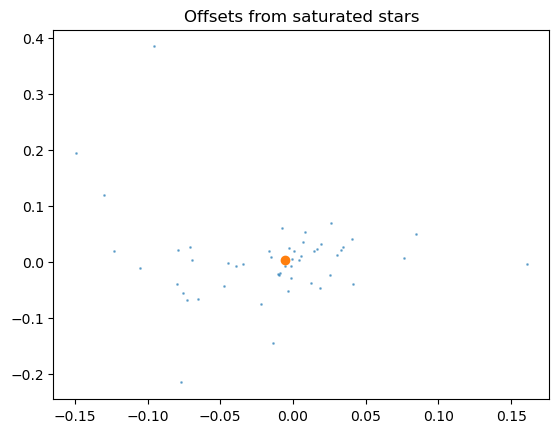

In [101]:
pl.title("Offsets from saturated stars")
pl.scatter(dra_s, ddec_s, s=1, alpha=0.5)
pl.scatter(np.median(dra_s), np.median(ddec_s));

In [102]:
# for each coordinate in DAO catalog, find VVV match (for plotting)
daoitercrd_nosat = daoitertbl_nosat['skycoord_centroid']
idx, sidx, sep, sep3d = daoitercrd_nosat.search_around_sky(vvvdr2_crds, 0.5*u.arcsec)
dra = (daoitercrd_nosat[sidx].ra - vvvdr2_crds[idx].ra).to(u.arcsec)
ddec = (daoitercrd_nosat[sidx].dec - vvvdr2_crds[idx].dec).to(u.arcsec)
len(idx), len(daoitercrd), len(vvvdr2_crds)

(26035, 175208, 8700)

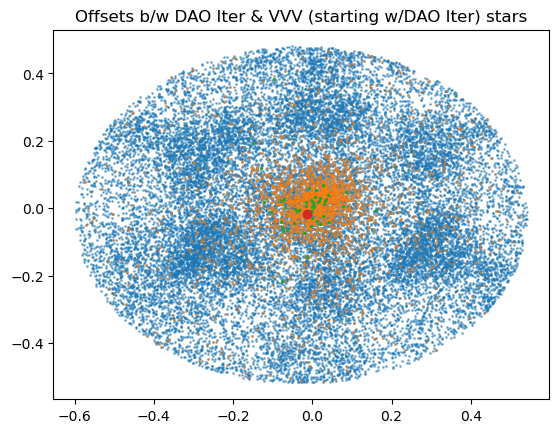

In [103]:
pl.title("Offsets b/w DAO Iter & VVV (starting w/DAO Iter) stars")
pl.scatter(dra, ddec, s=1, alpha=0.5)
bright = daoitertbl_nosat['flux_fit'][sidx] > 1e4
pl.scatter(dra[bright], ddec[bright], s=1, alpha=0.5)
pl.scatter(dra_s, ddec_s, s=2, alpha=1)
pl.scatter(np.median(dra), np.median(ddec));

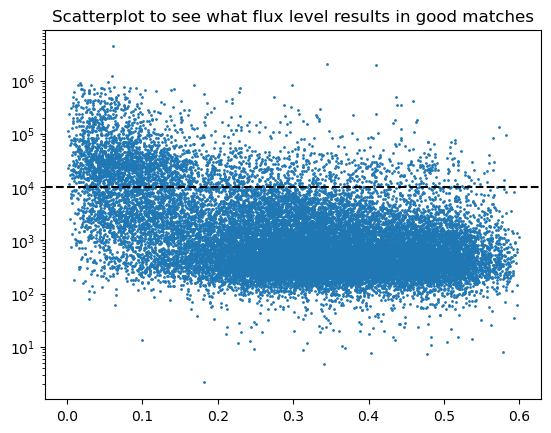

In [104]:
pl.title("Scatterplot to see what flux level results in good matches")
pl.scatter((dra**2 + ddec**2)**0.5, daoitertbl_nosat['flux_fit'][sidx], s=1)
pl.semilogy();
pl.axhline(1e4, color='k', linestyle='--');

In [105]:
# for each coordinate in DAO catalog, find VVV match (for saving)
daoitercrd_nosat = daoitertbl_nosat['skycoord_centroid']
bright = daoitertbl_nosat['flux_fit'] > 1e4
idxd, sepd, _ = daoitercrd_nosat[bright].match_to_catalog_sky(vvvdr2_crds)

drad = (daoitercrd_nosat[bright].ra - vvvdr2_crds[idxd].ra).to(u.arcsec)
ddecd = (daoitercrd_nosat[bright].dec - vvvdr2_crds[idxd].dec).to(u.arcsec)

# then, for each vvv object, find the closest DAO
idxv, sepv, _ = vvvdr2_crds.match_to_catalog_sky(daoitercrd_nosat[bright])
drav = (daoitercrd_nosat[bright][idxv].ra - vvvdr2_crds.ra).to(u.arcsec)
ddecv = (daoitercrd_nosat[bright][idxv].dec - vvvdr2_crds.dec).to(u.arcsec)

len(idxd), len(idxv), bright.sum(), len(vvvdr2_crds)

(5355, 8700, 5355, 8700)

(-0.5, 0.5, -0.5, 0.5)

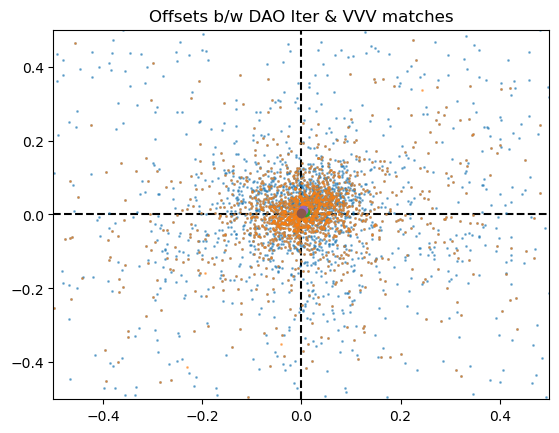

In [106]:
pl.title("Offsets b/w DAO Iter & VVV matches")
pl.scatter(drad, ddecd, s=1, alpha=0.5)
pl.scatter(drav, ddecv, s=1, alpha=0.5)
pl.scatter(np.median(drad), np.median(ddecd));
pl.scatter(np.median(drav), np.median(ddecv));
pl.scatter(np.median(drad[sepd<0.15*u.arcsec]), np.median(ddecd[sepd<0.15*u.arcsec]));
pl.scatter(np.median(drav[sepv<0.15*u.arcsec]), np.median(ddecv[sepv<0.15*u.arcsec]));
pl.axhline(0, color='k', linestyle='--', zorder=-5)
pl.axvline(0, color='k', linestyle='--', zorder=-5);
pl.axis([-0.5,0.5,-0.5,0.5])

# Conclusions again: There's no offset?

So, what the hell?  Why do the catalogs _look_ so offset when overlaid on the data?

Maybe it's just that the catalogs have never run to completion on the final data.

## Revisiting VVV x-matching June 28, 2023

Examining the VVV catalog overlaid on the realigned catalogs in `refcat_to_410_check` in CARTA, it looks like there are very few stars that actually get matched to JWST stars reasonably.

So a more careful treatment of the x-matching is needed.


Manual inspection, going 12..13, 14..15, etc., the first magnitude bin that is OK for F410M is 15..16, so >15 seems appropriate.

For F405N, though, >11 mag works

# Some plots for the paper

todo - show that offset ~ zero

(the paper plot is made in ColorVsCOIceAnalysis now)

In [107]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [108]:
import sys
if '' in sys.path:
    sys.path.remove('')

In [109]:
%run $basepath/analysis/analysis_setup.py
basetable = basetable_merged

2024-08-04 15:03:43,776 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/brick//reduction/filtering.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-08-04 15:03:43,777 - stpipe - WARNING -   from tqdm.autonotebook import tqdm
2024-08-04 15:03:43,778 - stpipe - WARNING - 
2024-08-04 15:03:49,470 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T02:38:56.308' from MJD-BEG.
2024-08-04 15:03:49,471 - stpipe - WARNING - Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
2024-08-04 15:03:49,472 - stpipe - WARNING - Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'.
2024-08-04 15:03:49,473 - stpipe - WARNING -   warnings.warn(
2024-08-04 15:03:49,474 - stpipe - WARNING - 
2024-08-04 15:03:49,474 - stpipe - WARNING - /orange/a

For module merged catalog crowdsource_nsky0_merged_photometry_tables_merged.fits, mod date is 2024-07-12 21:04:29
For module merged-reproject catalog crowdsource_nsky0_merged-reproject_photometry_tables_merged.fits, mod date is 2024-07-10 08:27:09


NameError: name 'basetable_merged' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
%run $basepath/analysis/selections.py --module=merged
assert len(basetable) == len(basetable_merged)

In [ ]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(basetable['skycoord_f410m'], 0.5*u.arcsec)
dra = (basetable['skycoord_f410m'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (basetable['skycoord_f410m'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

In [ ]:
%run $basepath/reduction/align_to_catalogs.py

In [ ]:
vvvdr2_crds, vvvdr2 = retrieve_vvv(basepath=basepath, filtername=filtername, module='merged',
                                   fov_regname='regions_/nircam_brick_fov.reg')
reference_coordinates = vvvdr2_crds

In [ ]:
skycrds_cat = basetable['skycoord_f410m']
skycrds_cat_mrgrep = basetable_merged_reproject['skycoord_f410m']
#skycrds_cat_a = basetable_nrca['skycoord_f410m']
#skycrds_cat_b = basetable_nrcb['skycoord_f410m']
idx, sidx, sep, sep3d = reference_coordinates.search_around_sky(skycrds_cat[all_good], 0.4*u.arcsec)
idxmr, sidxmr, sepmr, sep3dmr = reference_coordinates.search_around_sky(skycrds_cat_mrgrep[all_good_mr], 0.4*u.arcsec)
#idxa, sidxa, sepa, sep3da = reference_coordinates.search_around_sky(skycrds_cat_a[all_good_a], 0.4*u.arcsec)
#idxb, sidxb, sepb, sep3db = reference_coordinates.search_around_sky(skycrds_cat_b[all_good_b], 0.4*u.arcsec)

# Flux Calibration Check

### F212 vs VVVK plot

There are significant differences betwen NRCA, NRCB, and merged.

They are strict offsets in magnitude, so I guess multiplicative?

In [ ]:
pl.scatter(basetable['mag_ab_f212n'][all_good][idx], vvvdr2['Ksmag3'][sidx], marker=',', s=1, alpha=0.25, color='k', label='Both')
pl.scatter(basetable_merged_reproject['mag_ab_f212n'][all_good_mr][idxmr], vvvdr2['Ksmag3'][sidxmr],
           marker=',', s=1, alpha=0.25, color='r', label='M-R')
#pl.scatter(basetable_nrca['mag_ab_f212n'][all_good_a][idxa], vvvdr2['Ksmag3'][sidxa], marker='x', s=8, alpha=0.5, label='NRCA')
#pl.scatter(basetable_nrcb['mag_ab_f212n'][all_good_b][idxb], vvvdr2['Ksmag3'][sidxb], marker='x', s=8, alpha=0.5, label='NRCB')
pl.plot([12,18], [12,18])
pl.legend(loc='best')
pl.xlabel("[F212N]")
pl.ylabel("[K$_s$] (VVV)");

#### Why are there sources in 'basetable' not in nrca/nrcb?

## Using the "good" merged table, compare NRCA/NRCB fluxes

In [ ]:
nrcasel = regions.Regions.read('regions_/brick_nrca.reg')[0].contains(skycrds_cat_mrgrep[all_good_mr][idxmr], ww_mr)
nrcbsel = regions.Regions.read('regions_/brick_nrcb.reg')[0].contains(skycrds_cat_mrgrep[all_good_mr][idxmr], ww_mr)
pl.scatter(basetable_merged_reproject['mag_ab_f212n'][all_good_mr][idxmr], vvvdr2['Ksmag3'][sidxmr],
           marker=',', s=1, alpha=0.25, color='r', label='M-R')
#pl.scatter(basetable_merged_reproject['mag_ab_f212n'][all_good_mr][idxmr][nrcasel], vvvdr2['Ksmag3'][sidxmr][nrcasel],
#           marker='x', s=8, alpha=0.25,  label='NRCA')
#pl.scatter(basetable_merged_reproject['mag_ab_f212n'][all_good_mr][idxmr][nrcbsel], vvvdr2['Ksmag3'][sidxmr][nrcbsel],
#           marker='x', s=8, alpha=0.25,  label='NRCB')
pl.plot([12,18], [12,18])
pl.legend(loc='best')
pl.xlabel("[F212N]")
pl.ylabel("[K$_s$] (VVV)");

Now it looks like there's no problem, just an expected wavelength-driven offset


# Crossmatch galnuc w/"best"

In [ ]:
# Crossmatch galnuc w/"best"
threshold = 0.2*u.arcsec
idx, sidx, sep, sep3d = galnuc2021_crds.search_around_sky(skycrds_cat_mrgrep, threshold)
idx2, sidx2, sep2, sep3d2 = skycrds_cat_mrgrep.search_around_sky(galnuc2021_crds, threshold)
idxmatch, sepmatch, _ = coordinates.match_coordinates_sky(galnuc2021_crds, skycrds_cat_mrgrep)
len(idx), len(sidx), len(idx2), len(sidx2), len(idxmatch), (sepmatch < threshold).sum()

In [ ]:
gn_overlap = regions.Regions.read(f'{basepath}/regions_/galacticnucleusoverlap.reg')[0]

In [ ]:
gn_overlap.contains(galnuc2021_crds, wcs=ww).sum()

In [ ]:
gn_overlap.contains(basetable_merged_reproject['skycoord_f212n'][basetable_merged_reproject['good_f212n']], wcs=ww).sum()

In [ ]:
gn_overlap.contains(basetable_merged_reproject['skycoord_f212n'][all_good_mr], wcs=ww).sum()

In [ ]:
gn_overlap.contains(basetable_merged_reproject['skycoord_f212n'][short_good_mr], wcs=ww).sum()

In [ ]:
len(basetable_merged_reproject)

In [ ]:
short_good_mr[idxmatch[sepmatch < threshold]].sum()

In [ ]:
allgood_short_mr[idxmatch[sepmatch < threshold]].sum()

In [ ]:
all_good_mr[idxmatch[sepmatch < threshold]].sum()

## Merge GALACTICNUCLEUS

In [ ]:
galnuc_merged = table.hstack([galnuc2021[(sepmatch < threshold)], basetable_merged_reproject[idxmatch[sepmatch<threshold]]])
galnuc_merged.write(f'{basepath}/catalogs/GALACTICNUCLEUS_2021_merged.fits', overwrite=True)

In [ ]:
# use only the closest-match ones
idx = idxmatch[sepmatch<threshold]
sidx = sepmatch < threshold

In [ ]:
ok = all_good_mr[idx]
pl.scatter((galnuc_merged['Hmag'] - galnuc_merged['Ksmag'])[ok],
           (galnuc_merged['mag_ab_f212n'] - galnuc_merged['mag_ab_f466n'])[ok], s=3, alpha=0.25)
pl.xlabel("[H]-[K]")
pl.ylabel("[F212N] - [F466N]");
pl.ylim(-0.5, 3.5);

In [ ]:
ok = all_good_mr[idx]
pl.scatter((galnuc2021[sidx]['Hmag'] - galnuc2021[sidx]['Ksmag'])[ok],
           (basetable_merged_reproject[idx]['mag_ab_f212n'] - basetable_merged_reproject[idx]['mag_ab_f466n'])[ok], s=3, alpha=0.25)
pl.xlabel("[H]-[K]")
pl.ylabel("[F212N] - [F466N]");
pl.ylim(-0.5, 3.5);

In [ ]:
ok = all_good_mr[idx]
pl.scatter((galnuc_merged['Hmag'] - galnuc_merged['Ksmag'])[ok],
           (galnuc_merged['mag_ab_f405n'] - galnuc_merged['mag_ab_f466n'])[ok], s=3, alpha=0.25)
pl.xlabel("[H]-[K]")
pl.ylabel("[F405N] - [F466N]");
pl.ylim(-2, 1.5);

In [ ]:
ok = all_good_mr[idx]
pl.scatter((galnuc_merged['Hmag'] - galnuc_merged['Ksmag'])[ok],
           (galnuc_merged['mag_ab_f410m'] - galnuc_merged['mag_ab_f466n'])[ok], s=3, alpha=0.25)
pl.xlabel("[H]-[K]")
pl.ylabel("[F410M] - [F466N]");
pl.ylim(-2, 1.5);
ok.sum()

In [ ]:
ok = galnuc_merged['good_f187n'] & galnuc_merged['good_f212n']
pl.scatter((galnuc_merged['Hmag'] - galnuc_merged['Ksmag'])[ok],
           (galnuc_merged['mag_ab_f187n'] - galnuc_merged['mag_ab_f212n'])[ok], s=3, alpha=0.25)
pl.xlabel("[H]-[K]")
pl.ylabel("[F187N] - [F212N]");
pl.ylim(0, 1.5);
ok.sum()

In [ ]:
ok = galnuc_merged['good_f187n'] & galnuc_merged['good_f212n']
pl.scatter(( galnuc_merged['Ksmag'])[ok],
           ( galnuc_merged['mag_ab_f212n'])[ok], s=3, alpha=0.25)
pl.plot([10,20],[10,20])
pl.xlabel("[K]")
pl.ylabel("[F212N]");
#pl.ylim(0, 1.5);
ok.sum()

In [ ]:
ax = pl.subplot(1,1,1, projection=WCS(fits.getheader(imfile, ext=1)))
ax.scatter_coord(galnuc_merged['skycoord_ref'], s=1)
data = fits.getdata(imfile, ext=1)
ax.imshow(data, norm=simple_norm(data, max_percent=99, min_percent=1, stretch='log'), cmap='gray')